<a href="https://colab.research.google.com/github/ShawnLiu119/CapstoneProject_BankingMarketing/blob/main/BankMkting_Clustering_CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd 
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans, Birch

In [5]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
url = 'https://raw.githubusercontent.com/ShawnLiu119/CapstoneProject_BankingMarketing/main/rawdata/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

### General Function Setup

In [18]:
data_2 = data.copy()
data_2.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [19]:
##Since we are segmenting customers, the non customer-relevant features are going to be dropped such as macro economic indicator
df_clus = data_2[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 'pdays', 'poutcome', 'y']]

In [20]:
df_clus['y'] = df_clus['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))

In [21]:
cols = df_clus.columns

num_cols = df_clus._get_numeric_data().columns

cat_col = list(set(cols) - set(num_cols))

cat_col 

['marital', 'default', 'loan', 'poutcome', 'education', 'housing', 'job']

In [22]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

for col in cat_col:
  df_clus[col] = label.fit_transform(df_clus[col])

df_clus.head()

,age,job,marital,education,default,housing,loan,duration,pdays,poutcome,y
0,56,3,1,0,0,0,0,261,999,1,0
1,57,7,1,3,1,0,0,149,999,1,0
2,37,7,1,3,0,2,0,226,999,1,0
3,40,0,1,1,0,0,0,151,999,1,0
4,56,7,1,3,0,0,2,307,999,1,0


###Data Normalization - Standardscale

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(df_clus)

###PCA Applied before doing clustering to reduce dimensionality

In [24]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)

pca.explained_variance_ratio_

array([0.16109964, 0.14008793, 0.10941848, 0.1003905 , 0.09494452,
       0.08682102, 0.08669922, 0.07145662, 0.05887838, 0.05061876,
       0.03958493])

Text(0, 0.5, 'Cumulative explained variance')

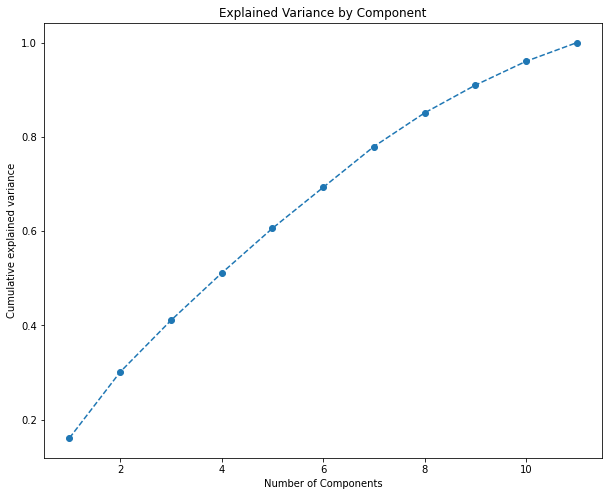

In [26]:
plt.figure(figsize = (10, 8))
plt.plot(range(1,12), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative explained variance')

In [60]:
#there is no obvious infection point on the curve, so we will use 80% as threshold to determine the number of principal component

pca = PCA(n_components = 7)

x_pca = pca.fit_transform(x)

### KMeans Clustering

In [34]:
wcss = []

for i in range(1, 21):
  kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans_pca.fit(x_pca)
  wcss.append(kmeans_pca.inertia_)

Text(0, 0.5, 'WCSS-Within-Cluster Sum of Square')

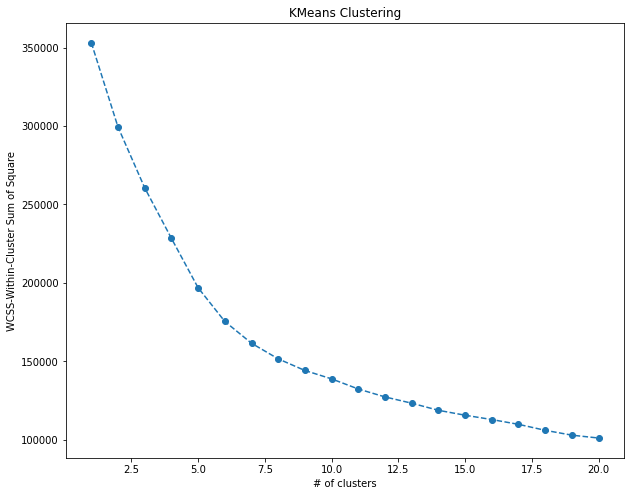

In [35]:
plt.figure(figsize = (10, 8))
plt.plot(range(1,21), wcss, marker='o', linestyle = '--')
plt.title('KMeans Clustering')
plt.xlabel('# of clusters')
plt.ylabel('WCSS-Within-Cluster Sum of Square')

And from this graph, we determine the number of clusters we’d like to keep. To that effect, we use the Elbow-method. The approach consists of looking for a kink or elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. In this instance, the kink comes at the 4 clusters mark. So, we’ll be keeping a four-cluster solution.

In [43]:
kmeans_pca = KMeans(n_clusters=5, init = 'k-means++', random_state=42)
kmeans_pca.fit(x_pca)

KMeans(n_clusters=5, random_state=42)

In [65]:
# Before all else, we’ll create a new data frame. It allows us to add in the values of the separate components to our segmentation data set. The components’ scores are stored in the ‘scores P C A’ variable. Let’s label them Component 1, 2 and 3. In addition, we also append the ‘K means P C A’ labels to the new data frame.

df_segmentation = data_2[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 'pdays', 'poutcome', 'y']]


In [66]:
df_seg_kmean = pd.concat([df_segmentation, pd.DataFrame(x_pca)], axis = 1)
df_seg_kmean.columns.values[-7:] = ['Comp1', 'Comp2','Comp3','Comp4','Comp5','Comp6','Comp7']

df_seg_kmean ['cluster_label'] = kmeans_pca.labels_
df_seg_kmean.head(10)

,age,job,marital,education,default,housing,loan,duration,pdays,poutcome,y,Comp1,Comp2,Comp3,Comp4,Comp5,Comp6,Comp7,cluster_label
0,56,housemaid,married,basic.4y,no,no,no,261,999,nonexistent,no,-0.640537,1.547422,0.078671,-0.411936,-0.939176,0.581371,-0.323710,0
1,57,services,married,high.school,unknown,no,no,149,999,nonexistent,no,-0.941106,1.788026,-0.569360,0.316186,-1.200333,-0.299727,1.559731,0
2,37,services,married,high.school,no,yes,no,226,999,nonexistent,no,-0.136472,-0.253236,-0.301470,0.626802,0.206516,-0.952029,-0.190458,4
3,40,admin.,married,basic.6y,no,no,no,151,999,nonexistent,no,-0.624216,0.519635,-0.159462,-1.187937,-0.849821,0.787208,-0.809673,0
4,56,services,married,high.school,no,no,yes,307,999,nonexistent,no,-0.240205,0.873396,-0.101243,0.942933,0.800062,2.077514,1.353590,1
5,45,services,married,basic.9y,unknown,no,no,198,999,nonexistent,no,-0.852439,1.291999,-0.395517,-0.312721,-1.203177,-0.430462,1.700838,0
6,59,admin.,married,professional.course,no,no,no,139,999,nonexistent,no,-0.480920,0.928848,-0.388029,0.361557,-0.893795,1.131175,-1.089833,0
7,41,blue-collar,married,unknown,unknown,no,no,217,999,nonexistent,no,-0.520344,0.429587,-0.405953,-0.288266,-1.053327,0.270507,0.554440,0
8,24,technician,single,professional.course,no,yes,no,380,999,nonexistent,no,0.654984,-2.202682,-0.087829,0.377761,0.036437,-1.360463,0.639292,4
9,25,services,single,high.school,no,yes,no,50,999,nonexistent,no,0.011688,-1.885115,-0.768320,-0.347517,0.179040,-1.284770,0.207502,4


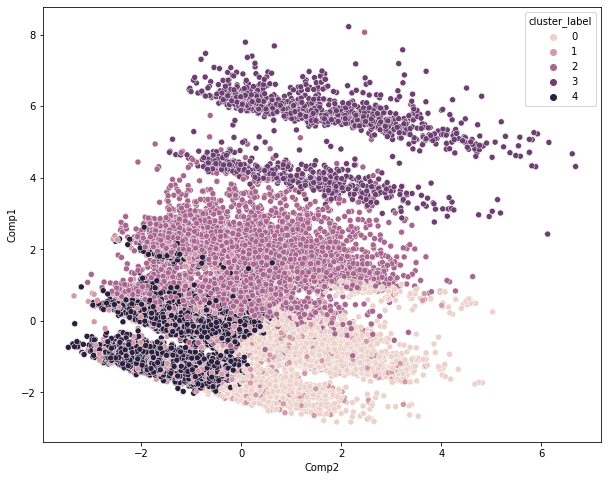

In [67]:
#visualize

plt.figure(figsize = (10, 8))
sns.scatterplot(data=df_seg_kmean, x="Comp2", y="Comp1", hue="cluster_label")
plt.show()

### Agglomerative Clustering


In [ ]:


agg_clu = AgglomerativeClustering(n_clusters=5)
y_agg = agg_clu.fit_predict(x)

In [ ]:
clusters = unique(y_agg)
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(y_agg == cluster)
	# create scatter of these samples
	pyplot.scatter(x[row_ix, 0], x[row_ix, 1])
# show the plot
pyplot.show()

0    36548
1     4640
Name: y, dtype: int64

In [ ]:
#drop the unknow columns as they are correlated to other categories



(41188, 56)